In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.8 MB/s eta 0:00:00


# Import necessary libraries


In [44]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import zscore

In [3]:
%cd "/content/drive/MyDrive/tasks/arul"

/content/drive/MyDrive/tasks/arul


# Load datasets

In [4]:
legitimate_df = pd.read_csv('datasetLegitimate33featues.csv')
malware_df = pd.read_csv('datasetMalware33featues.csv')

In [5]:
legitimate_df.head()

,FinFlagDist,SynFlagDist,RstFlagDist,PshFlagDist,AckFlagDist,DNSoverIP,TCPoverIP,UDPoverIP,MaxLen,MinLen,...,NumPorts,FlowLEN,FlowLENrx,repeated_pkts_ratio,NumCon,NumIPdst,Start_flow,DeltaTimeFlow,HTTPpkts,label
0,-1.204652,-1.407562,-0.716937,1.523823,2.656452,-0.154516,0.154711,-0.156991,0.717470,1.573610,...,-0.889691,2.861360,0.257564,1.307661,-0.190341,-0.194497,0.568223,1.071779,-0.772901,0.0
1,1.424353,2.041085,-0.716937,2.004106,2.360730,4.854153,-7.182148,6.836627,0.717470,0.179772,...,1.953765,2.329183,21.255366,-1.048332,5.253913,5.142781,0.568223,1.071785,-0.772901,0.0
2,-1.204652,-1.407562,-0.716937,1.922467,2.558935,-0.154516,0.154711,-0.156991,0.717470,1.573610,...,-0.889691,2.728955,0.320391,1.147767,-0.190341,-0.194497,0.568223,1.071610,-0.772901,0.0
3,-1.204652,-1.407562,-0.716937,1.573412,1.583931,-0.154516,0.154711,-0.156991,-0.101705,1.573610,...,-0.889691,1.345700,0.198833,-0.128315,-0.190341,-0.194497,0.568223,1.069820,-0.772901,0.0
4,-1.204652,-1.407562,-0.716937,1.606869,2.030431,-0.154516,0.154711,-0.156991,0.717470,1.573610,...,-0.889691,2.113445,0.035001,0.671842,-0.190341,-0.194497,0.568223,1.069551,-0.772901,0.0


In [6]:
malware_df.head()

,FinFlagDist,SynFlagDist,RstFlagDist,PshFlagDist,AckFlagDist,DNSoverIP,TCPoverIP,UDPoverIP,MaxLen,MinLen,...,NumPorts,FlowLEN,FlowLENrx,repeated_pkts_ratio,NumCon,NumIPdst,Start_flow,DeltaTimeFlow,HTTPpkts,label
0,0.478168,1.144246,-0.716937,0.671470,1.089129,-0.154516,0.154711,-0.156991,-0.009901,-1.028609,...,-0.889691,0.479515,0.284428,0.862578,5.253913,5.142702,0.562400,-0.052248,1.487787,1.0
1,-1.204652,0.316746,-0.716937,1.537622,1.135609,-0.154516,0.154711,-0.156991,0.722669,0.628640,...,0.293799,1.301840,-0.036629,-0.908981,-0.190341,-0.194497,0.562400,-0.315281,1.786307,1.0
2,-1.204652,-0.216194,-0.716937,-0.457715,-0.848148,-0.154516,0.154711,-0.156991,-0.172436,0.628640,...,-0.889691,-0.452523,-0.049479,-0.671509,-0.190341,-0.194497,0.562400,-1.197897,0.583908,1.0
3,0.478168,0.636365,-0.716937,1.615480,1.274407,-0.154516,0.154711,-0.156991,0.722669,0.628640,...,0.823293,1.416370,-0.042111,-1.626711,-0.190341,-0.194497,0.562400,-0.097754,1.805515,1.0
4,1.747840,1.867679,1.867097,0.903129,1.473227,6.778562,-7.182148,6.836627,0.485384,0.628640,...,1.116241,0.868445,0.678529,0.902818,5.253913,5.142781,0.563213,0.885878,1.614688,1.0


# Combine datasets

In [7]:
data = pd.concat([legitimate_df, malware_df], axis=0).reset_index(drop=True)

# Initial Data Exploration

In [8]:
data.head()

,FinFlagDist,SynFlagDist,RstFlagDist,PshFlagDist,AckFlagDist,DNSoverIP,TCPoverIP,UDPoverIP,MaxLen,MinLen,...,NumPorts,FlowLEN,FlowLENrx,repeated_pkts_ratio,NumCon,NumIPdst,Start_flow,DeltaTimeFlow,HTTPpkts,label
0,-1.204652,-1.407562,-0.716937,1.523823,2.656452,-0.154516,0.154711,-0.156991,0.717470,1.573610,...,-0.889691,2.861360,0.257564,1.307661,-0.190341,-0.194497,0.568223,1.071779,-0.772901,0.0
1,1.424353,2.041085,-0.716937,2.004106,2.360730,4.854153,-7.182148,6.836627,0.717470,0.179772,...,1.953765,2.329183,21.255366,-1.048332,5.253913,5.142781,0.568223,1.071785,-0.772901,0.0
2,-1.204652,-1.407562,-0.716937,1.922467,2.558935,-0.154516,0.154711,-0.156991,0.717470,1.573610,...,-0.889691,2.728955,0.320391,1.147767,-0.190341,-0.194497,0.568223,1.071610,-0.772901,0.0
3,-1.204652,-1.407562,-0.716937,1.573412,1.583931,-0.154516,0.154711,-0.156991,-0.101705,1.573610,...,-0.889691,1.345700,0.198833,-0.128315,-0.190341,-0.194497,0.568223,1.069820,-0.772901,0.0
4,-1.204652,-1.407562,-0.716937,1.606869,2.030431,-0.154516,0.154711,-0.156991,0.717470,1.573610,...,-0.889691,2.113445,0.035001,0.671842,-0.190341,-0.194497,0.568223,1.069551,-0.772901,0.0


In [9]:
data.shape

(64554, 34)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64554 entries, 0 to 64553
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FinFlagDist          64554 non-null  float64
 1   SynFlagDist          64554 non-null  float64
 2   RstFlagDist          64554 non-null  float64
 3   PshFlagDist          64554 non-null  float64
 4   AckFlagDist          64554 non-null  float64
 5   DNSoverIP            64554 non-null  float64
 6   TCPoverIP            64554 non-null  float64
 7   UDPoverIP            64554 non-null  float64
 8   MaxLen               64554 non-null  float64
 9   MinLen               64554 non-null  float64
 10  StdDevLen            64554 non-null  float64
 11  AvgLen               64554 non-null  float64
 12  MaxIAT               64554 non-null  float64
 13  MinIAT               64554 non-null  float64
 14  AvgIAT               64554 non-null  float64
 15  AvgWinFlow           64554 non-null 

# Summary Statistics

In [11]:
print(data.describe())

        FinFlagDist   SynFlagDist   RstFlagDist   PshFlagDist   AckFlagDist  \
count  6.455400e+04  6.455400e+04  6.455400e+04  6.455400e+04  6.455400e+04   
mean  -3.522224e-17 -9.510006e-17  1.902001e-16  2.307057e-16  2.465557e-16   
std    1.000008e+00  1.000008e+00  1.000008e+00  1.000008e+00  1.000008e+00   
min   -1.204652e+00 -1.407562e+00 -7.169369e-01 -1.350512e+00 -2.047207e+00   
25%   -1.204652e+00 -2.161944e-01 -7.169369e-01 -7.651495e-01 -7.270884e-01   
50%   -3.112059e-02 -2.161944e-01 -7.169369e-01  1.112646e-01  5.924374e-02   
75%    7.778985e-01  6.363655e-01  1.191003e+00  6.974030e-01  6.917300e-01   
max    2.548173e+00  2.748681e+00  1.893017e+00  2.665581e+00  2.988854e+00   

          DNSoverIP     TCPoverIP     UDPoverIP        MaxLen        MinLen  \
count  6.455400e+04  6.455400e+04  6.455400e+04  6.455400e+04  6.455400e+04   
mean   2.465557e-17 -1.638715e-15  2.289446e-17 -9.298672e-16  3.070954e-08   
std    1.000008e+00  1.000008e+00  1.000008e+00  1.

In [12]:
# Distribution of Target Variable
data['label'].value_counts()

,count
label,
1.0,34349
0.0,30205


# Data Visualization

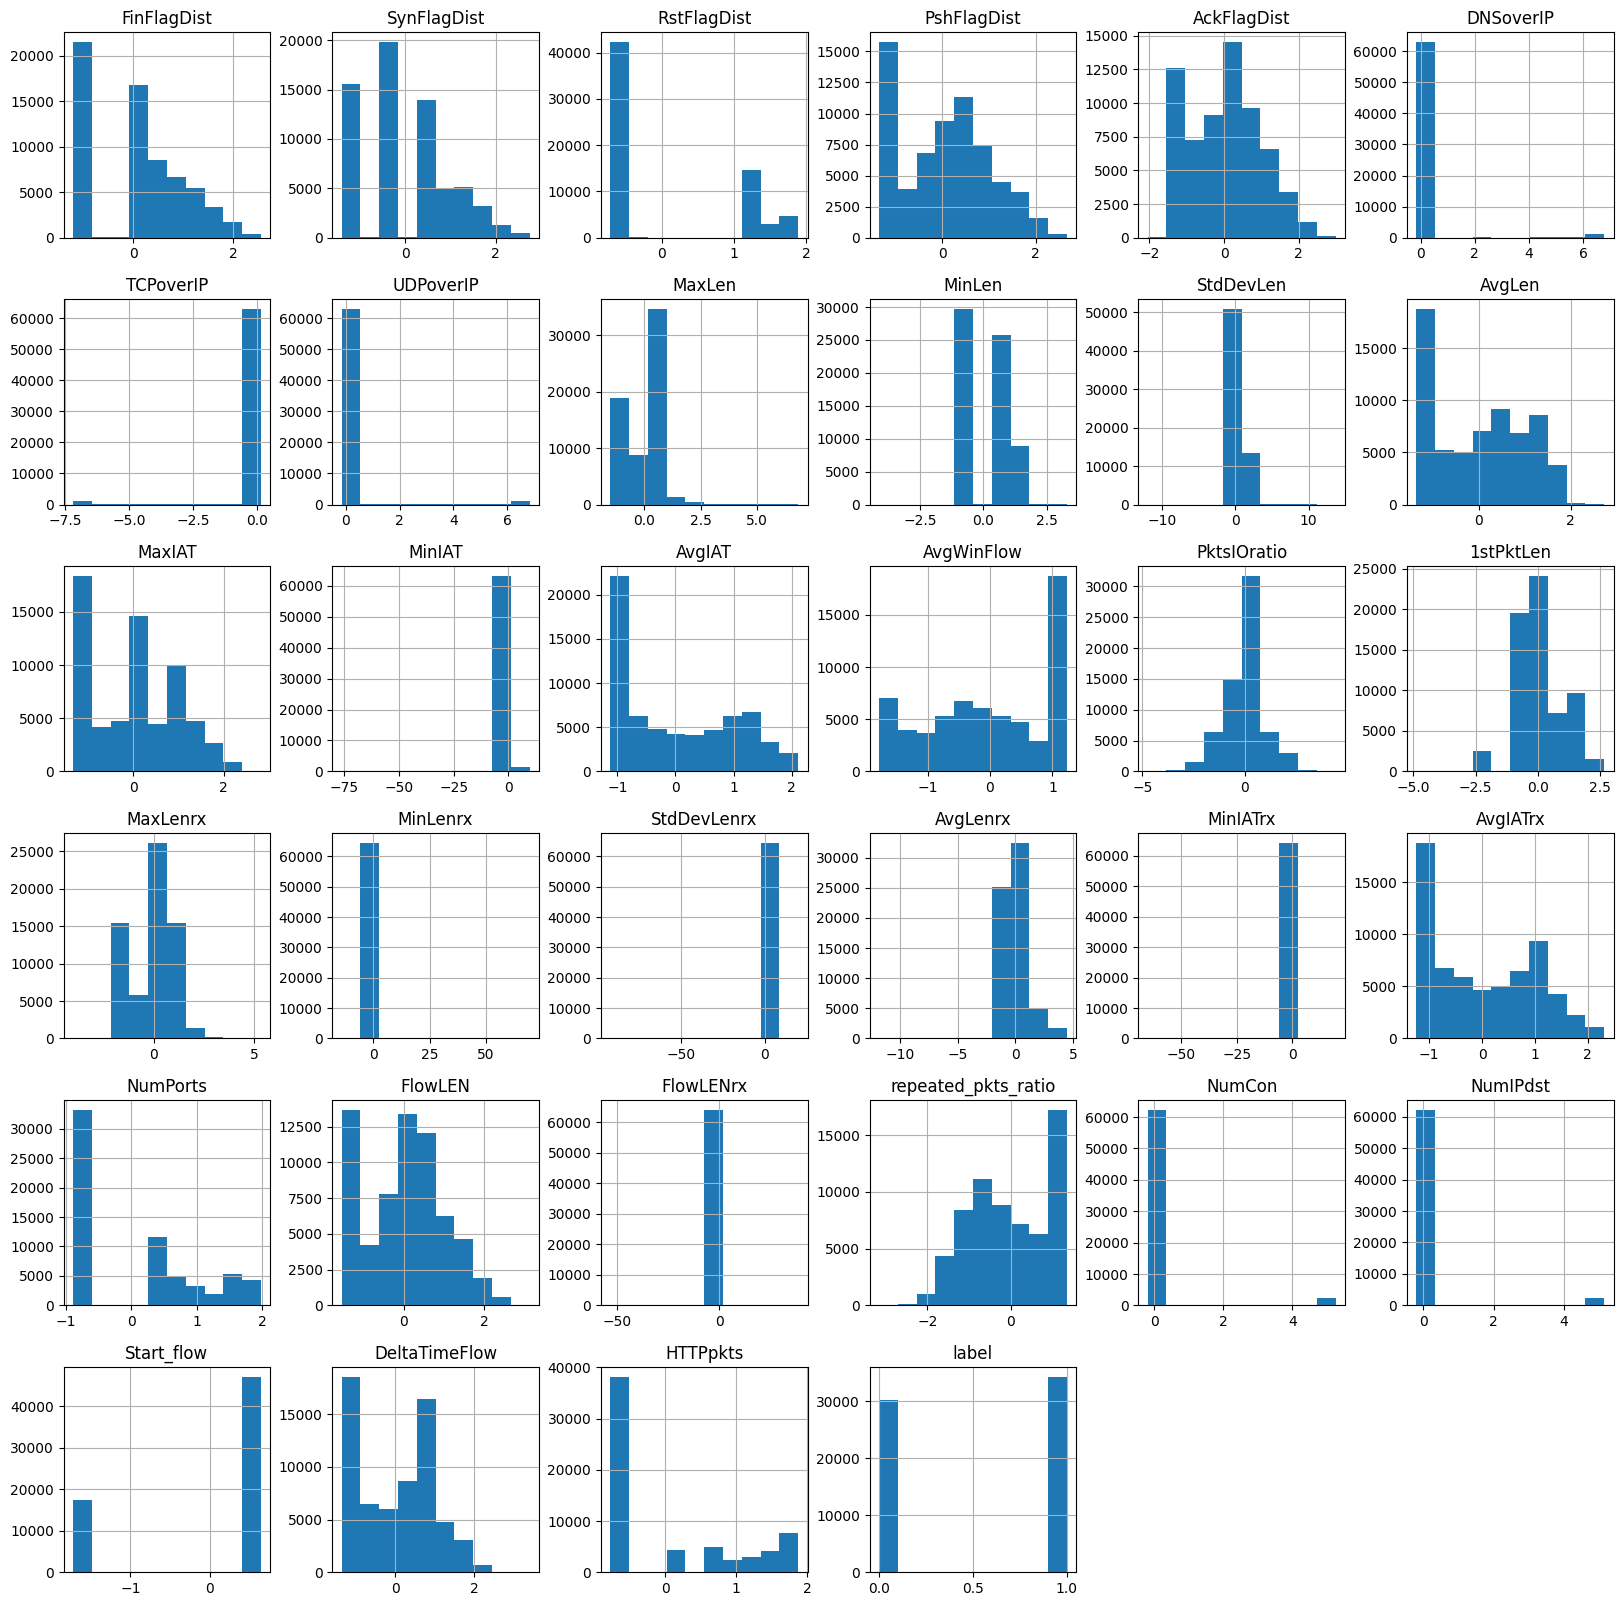

In [13]:
## Histograms - Distribution Plots
data.hist(figsize=(20, 20))
plt.show()

# Correlation Analysis

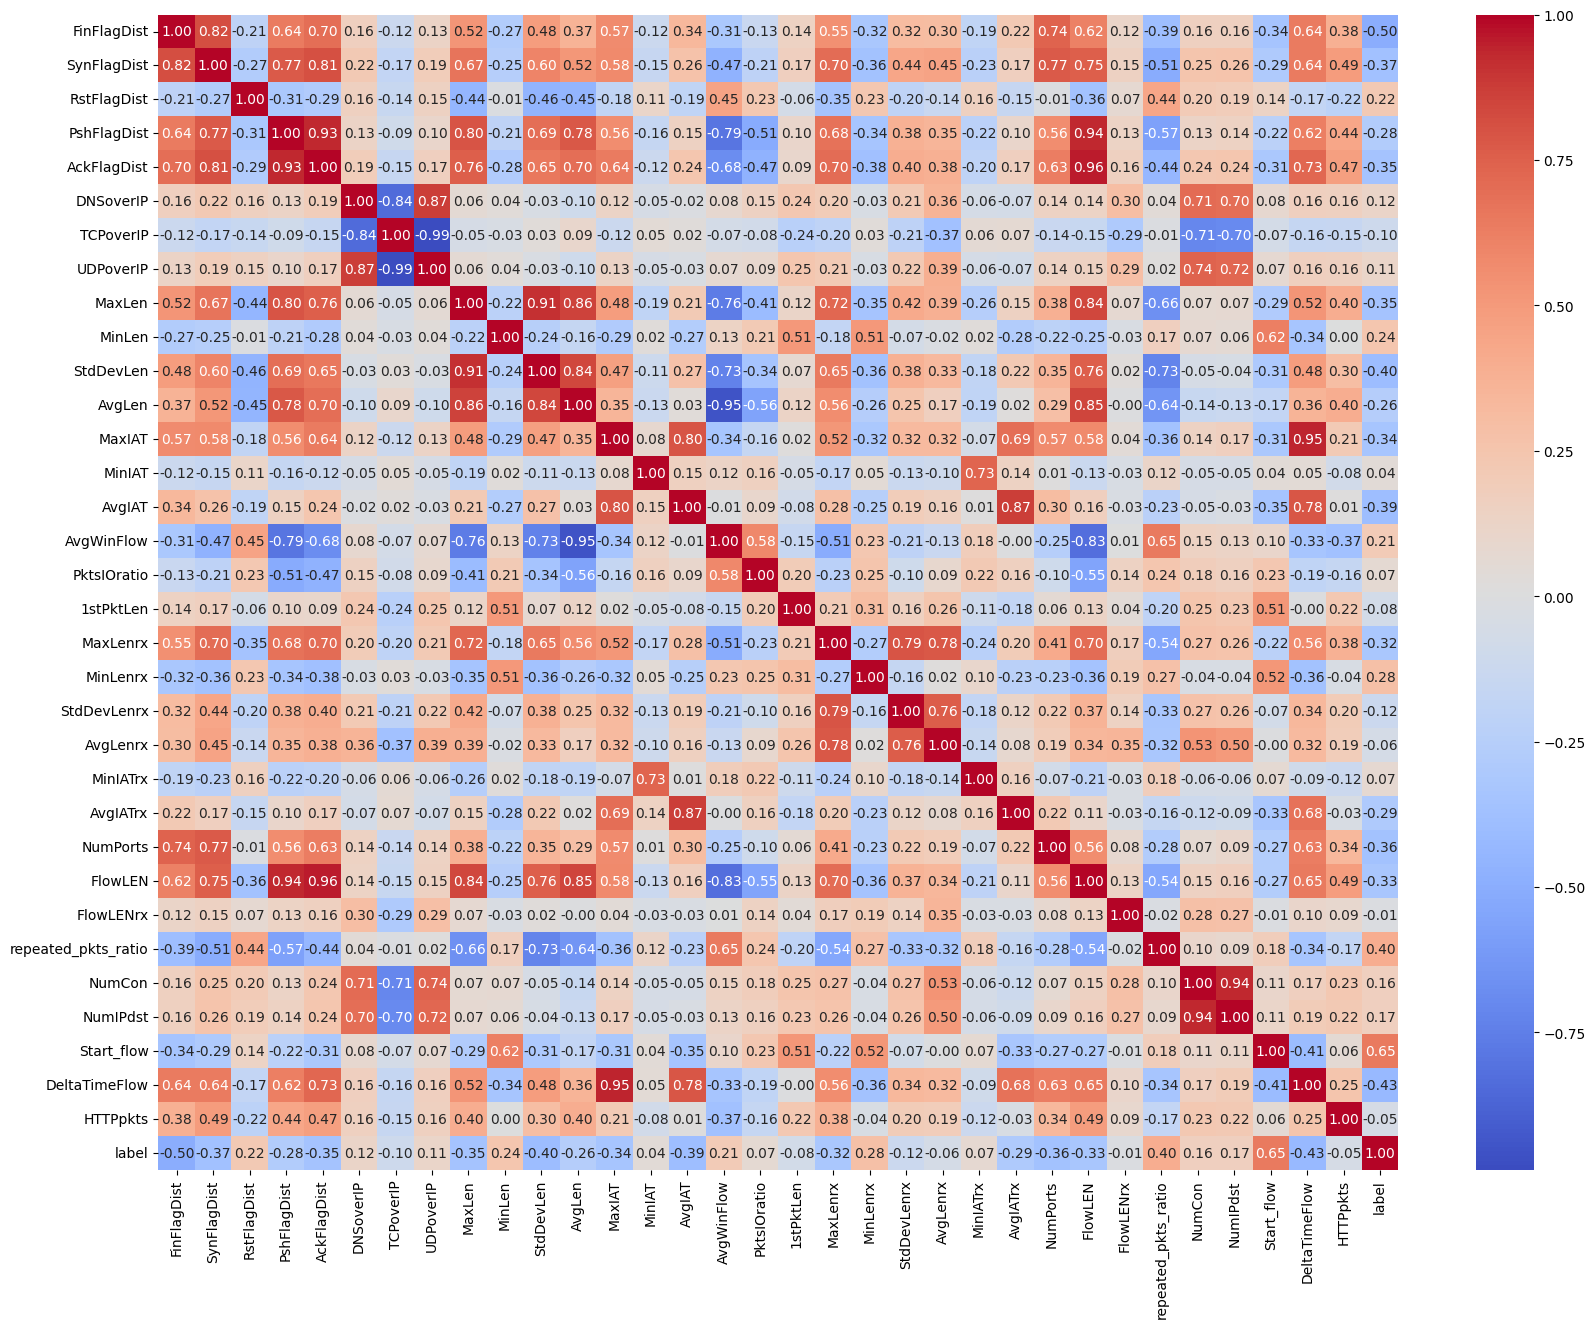

In [14]:
## Heatmap of Correlation Matrix
plt.figure(figsize=(20, 15))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [15]:
# Compute the correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.90
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.90)]

print("Features with high correlation (> 0.90):")
for feature in high_corr_features:
    correlated_with = upper.index[upper[feature] > 0.90].tolist()
    print(f"{feature} is highly correlated with {correlated_with}")


Features with high correlation (> 0.90):
AckFlagDist is highly correlated with ['PshFlagDist']
UDPoverIP is highly correlated with ['TCPoverIP']
StdDevLen is highly correlated with ['MaxLen']
AvgWinFlow is highly correlated with ['AvgLen']
FlowLEN is highly correlated with ['PshFlagDist', 'AckFlagDist']
NumIPdst is highly correlated with ['NumCon']
DeltaTimeFlow is highly correlated with ['MaxIAT']


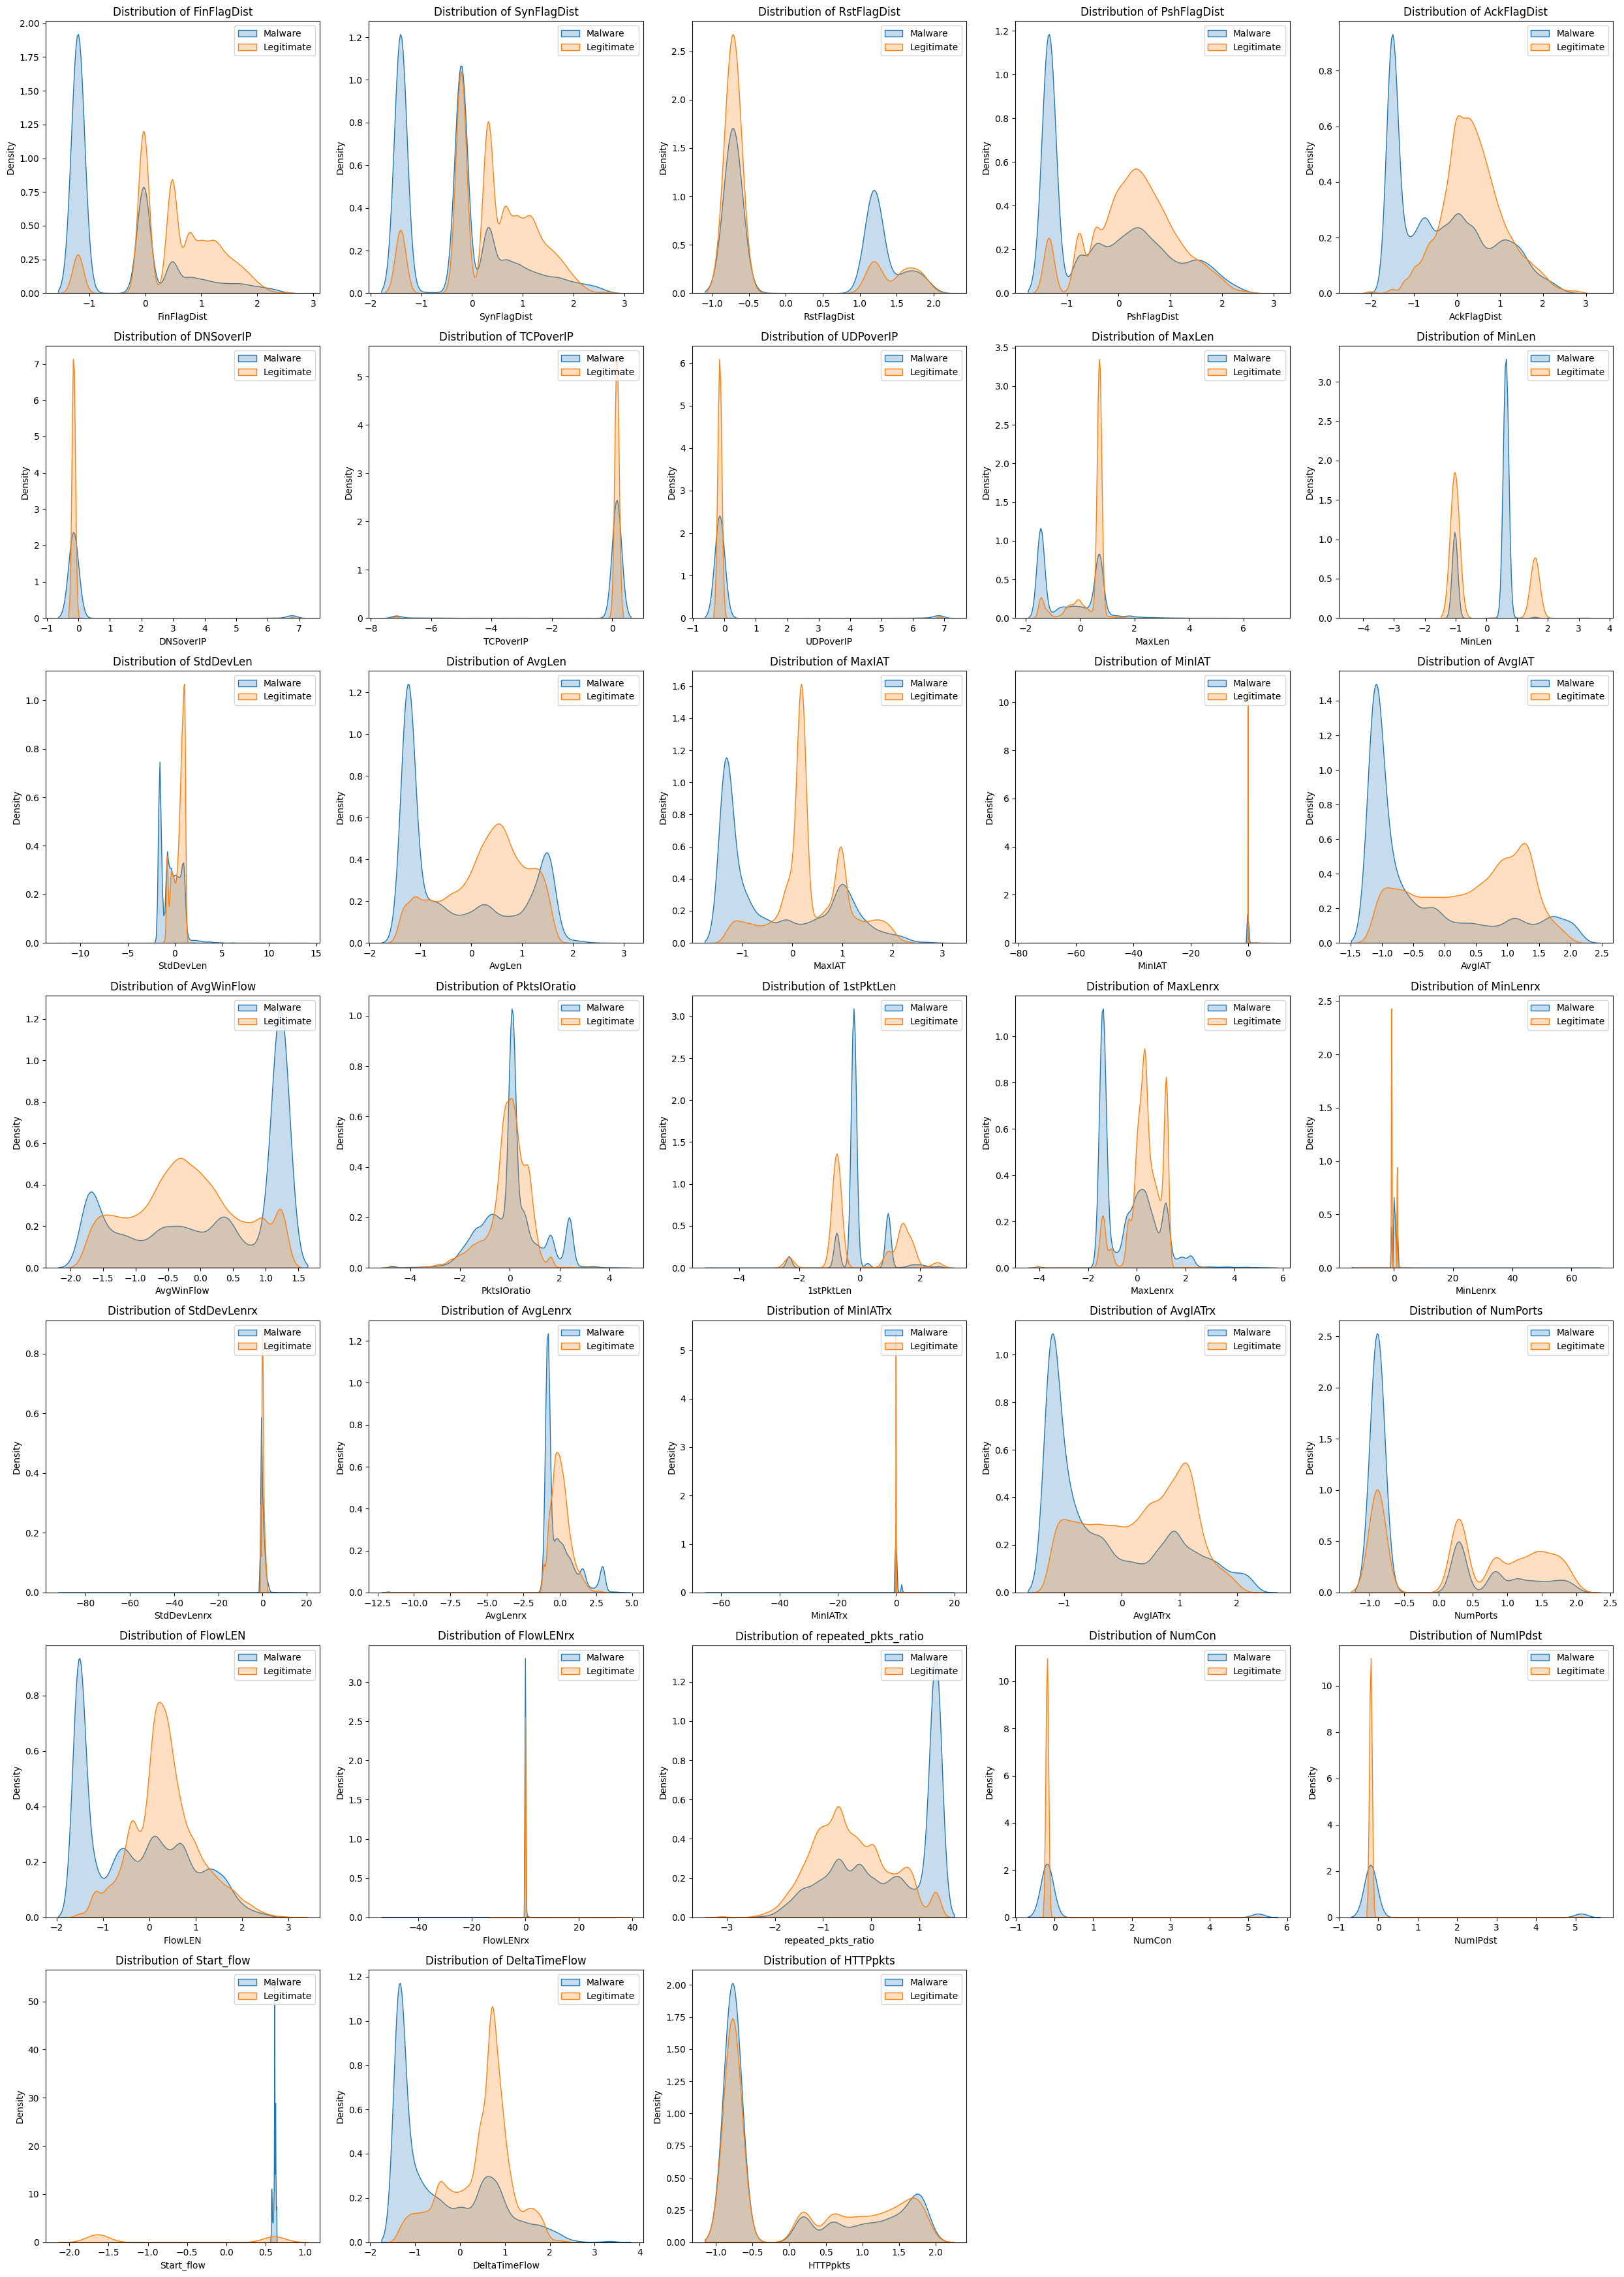

In [16]:
# Distribution by Class
malware = data[data['label'] == 1]
legitimate = data[data['label'] == 0]

# Define the number of rows and columns for the grid
num_features = len(data.columns) - 1
num_cols = 5
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, num_rows * 5))
axes = axes.flatten()

for i, column in enumerate(data.columns[:-1]):
    sns.kdeplot(malware[column], label='Malware', fill=True, ax=axes[i])
    sns.kdeplot(legitimate[column], label='Legitimate', fill=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].legend()

# Remove any unused subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

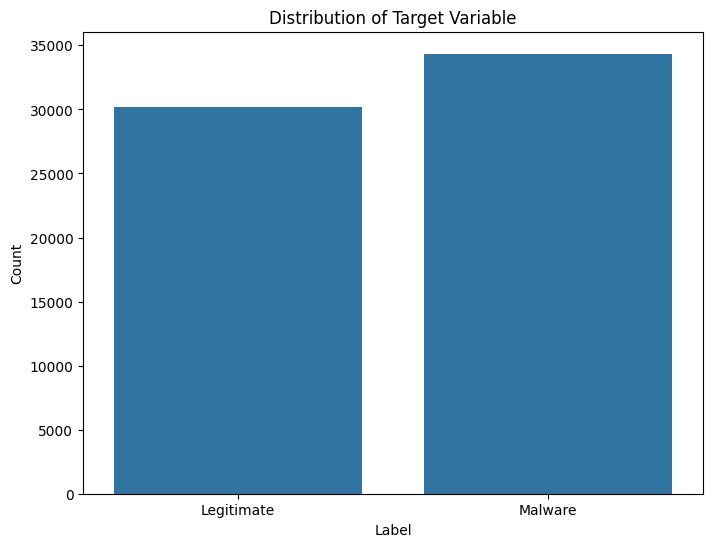

In [17]:
# Bar chart for target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=data)
plt.title('Distribution of Target Variable')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Legitimate', 'Malware'])
plt.show()

In [18]:
# Check for Missing Values
data.isna().sum()

,0
FinFlagDist,0
SynFlagDist,0
RstFlagDist,0
PshFlagDist,0
AckFlagDist,0
DNSoverIP,0
TCPoverIP,0
UDPoverIP,0
MaxLen,0
MinLen,0


In [19]:
# Function to check and print duplicate values count in each feature
def print_duplicates_count(data):
    for column in data.columns:
        duplicate_count = data[column].duplicated().sum()
        if duplicate_count > 0:
            print(f"Feature '{column}' has {duplicate_count} duplicate values.")
        else:
            print(f"Feature '{column}' has no duplicate values.")
        print("\n" + "-"*50 + "\n")

# Call the function with your dataset
print_duplicates_count(data)

Feature 'FinFlagDist' has 62973 duplicate values.

--------------------------------------------------

Feature 'SynFlagDist' has 62746 duplicate values.

--------------------------------------------------

Feature 'RstFlagDist' has 63172 duplicate values.

--------------------------------------------------

Feature 'PshFlagDist' has 61545 duplicate values.

--------------------------------------------------

Feature 'AckFlagDist' has 60422 duplicate values.

--------------------------------------------------

Feature 'DNSoverIP' has 63491 duplicate values.

--------------------------------------------------

Feature 'TCPoverIP' has 63407 duplicate values.

--------------------------------------------------

Feature 'UDPoverIP' has 63452 duplicate values.

--------------------------------------------------

Feature 'MaxLen' has 61946 duplicate values.

--------------------------------------------------

Feature 'MinLen' has 64513 duplicate values.

--------------------------------------

# Data Prepcessing

In [20]:
# Step 1: Remove Exact Duplicate Rows
data = data.drop_duplicates()

In [21]:
# Step 2: Remove Features with High Duplicate Counts
# Function to identify and remove features with a high percentage of duplicate values, excluding 'label'
def remove_high_duplicate_features(data, threshold=0.95):
    columns_to_remove = []
    for column in data.columns:
        if column == 'label':
            continue
        duplicate_ratio = data[column].duplicated().mean()
        if duplicate_ratio > threshold:
            columns_to_remove.append(column)
    data = data.drop(columns=columns_to_remove)
    return data

data = remove_high_duplicate_features(data, threshold=0.95)

In [22]:
data.shape

(64554, 18)

In [23]:
# Handle Missing Values
## Separate the label feature
label = data['label']
data = data.drop(columns=['label'])

## Remove features that are zeros across all samples
data = data.loc[:, (data != 0).any(axis=0)]

## Add the label feature back
data['label'] = label

In [24]:
data.shape

(64554, 18)

In [25]:
# Remove samples with unavailable feature values (NaN)
data = data.dropna(axis=0, how='any')

In [26]:
data.shape

(64554, 18)

In [27]:
# Remove features with many NaN values (≥ 50% missing values)
threshold = len(data) * 0.5
data = data.dropna(axis=1, thresh=threshold)

In [28]:
data.shape

(64554, 18)

In [29]:
# Separate features and labels before scaling
features = data.drop(columns=['label'])
label = data['label']

# Feature Scaling using PowerTransformer
scaler = PowerTransformer()
features_scaled = scaler.fit_transform(features)

In [30]:
# Convert back to DataFrame with the correct columns
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
data_processed = pd.concat([features_scaled_df, label.reset_index(drop=True)], axis=1)

In [31]:
data_processed.shape

(64554, 18)

In [32]:
data_processed.head()

,AckFlagDist,StdDevLen,AvgLen,MaxIAT,MinIAT,AvgIAT,AvgWinFlow,PktsIOratio,StdDevLenrx,AvgLenrx,MinIATrx,AvgIATrx,FlowLEN,FlowLENrx,repeated_pkts_ratio,Start_flow,DeltaTimeFlow,label
0,2.639128,-0.346232,1.581521,-0.572222,-0.107913,-1.182466,-1.654336,-2.547291,-0.665531,-0.678101,-0.145866,-1.211394,2.922419,0.270720,1.302131,0.447611,1.072866,0.0
1,2.347151,0.173558,-0.372288,-1.171254,-0.107914,-1.199787,0.430116,1.121662,1.277943,2.812886,-0.145878,-1.310198,2.369369,18.607948,-1.049484,0.447611,1.072871,0.0
2,2.542874,0.102658,1.558147,-0.545015,-0.107914,-1.162639,-1.630830,-1.351842,-0.769846,-0.686124,-0.145863,-1.233475,2.784592,0.334125,1.145007,0.447611,1.072694,0.0
3,1.578870,-0.005994,0.627979,0.320860,-0.107889,-0.204812,-1.096611,0.422028,1.945194,1.982566,-0.145854,-0.538989,1.354699,0.211242,-0.120492,0.447611,1.070882,0.0
4,2.020723,0.665215,1.481212,-0.117720,-0.107904,-0.857303,-1.440888,-0.949254,-0.877231,-0.760864,-0.145851,-0.882979,2.145905,0.044171,0.675732,0.447611,1.070610,0.0


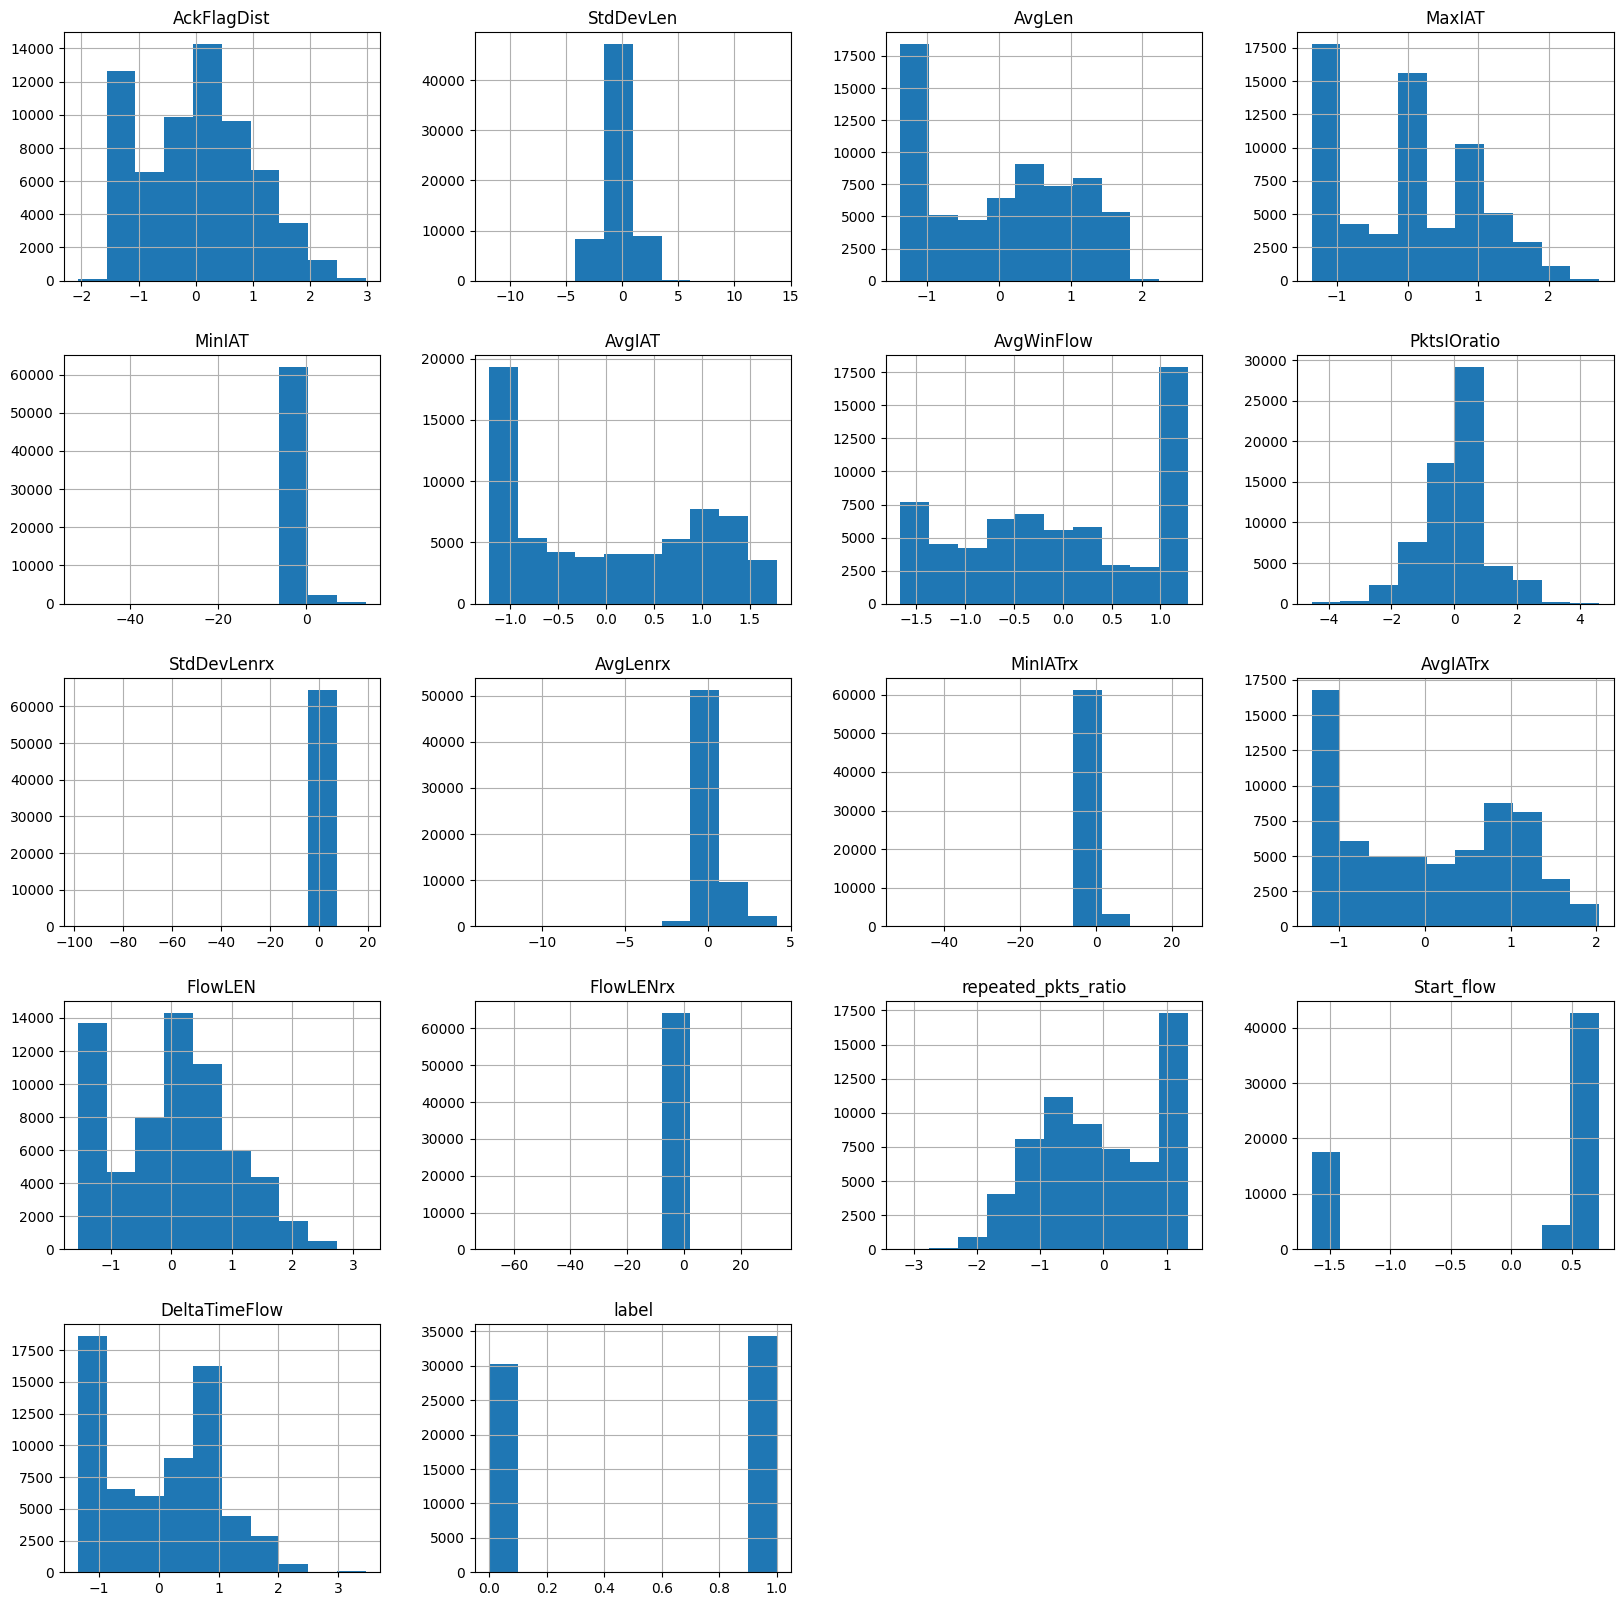

In [33]:
# Histograms - Distribution Plots after Preprocessing
data_processed.hist(figsize=(20, 20))
plt.show()

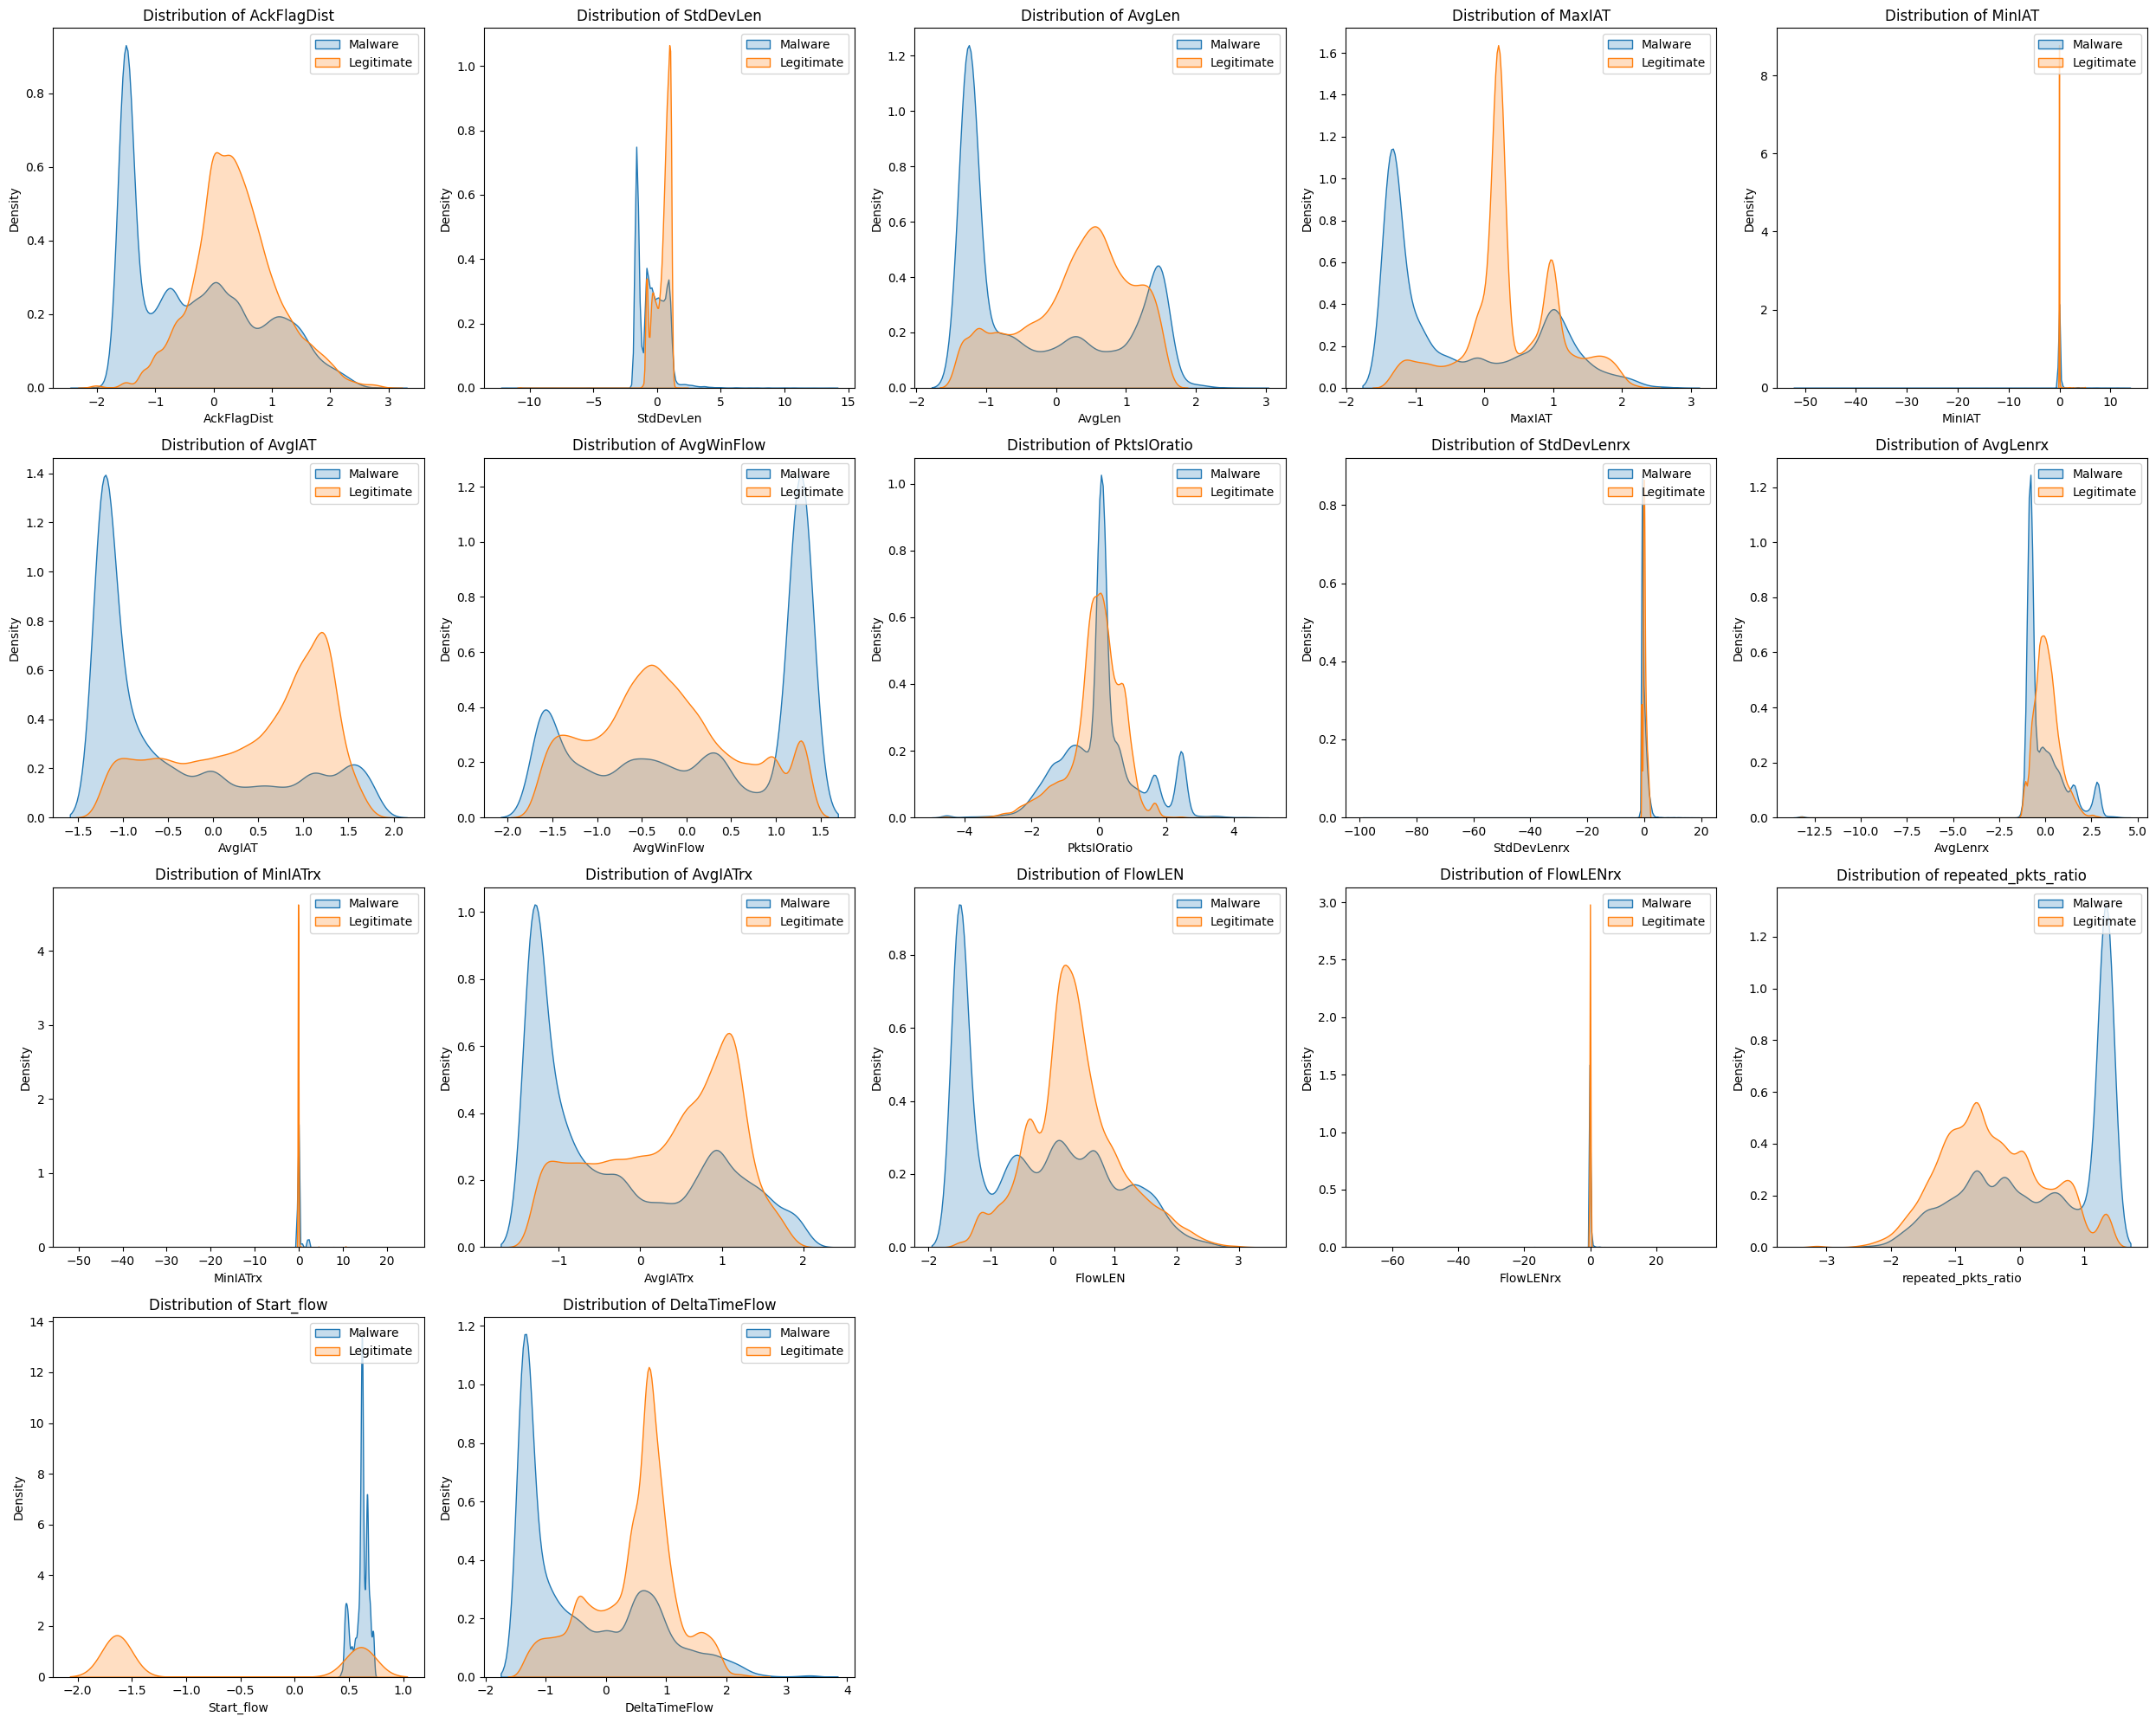

In [34]:
# Distribution by Class
malware = data_processed[data_processed['label'] == 1]
legitimate = data_processed[data_processed['label'] == 0]

# Define the number of rows and columns for the grid
num_features = len(data_processed.columns) - 1
num_cols = 5
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, num_rows * 5))
axes = axes.flatten()

for i, column in enumerate(data_processed.columns[:-1]):
    sns.kdeplot(malware[column], label='Malware', fill=True, ax=axes[i])
    sns.kdeplot(legitimate[column], label='Legitimate', fill=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].legend()

# Remove any unused subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Models Training and Evaluation

In [35]:
# Separate features and labels
X = data_processed.drop(columns=['label'])
y = data_processed['label']

In [36]:
# Split the Data into Training, Validation, and Testing Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [37]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [38]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {title}')
    plt.legend(loc="lower right")
    plt.show()

In [39]:
# # Function to evaluate and print model performance
def evaluate_model(model, X_test, y_test, title):
    y_pred = model.predict(X_test)

    # Handle both binary labels and one-hot encoded labels
    if isinstance(y_test, pd.DataFrame) or isinstance(y_test, np.ndarray):
        if y_test.ndim == 2:
            y_true = np.argmax(y_test, axis=1)
        else:
            y_true = y_test
    else:
        y_true = y_test

    # Check if the model has predict_proba method
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        if y_pred.ndim == 2:
            y_pred_proba = y_pred[:, 1]
            y_pred = np.argmax(y_pred, axis=1)
        else:
            y_pred_proba = y_pred

    y_pred_labels = np.argmax(y_pred, axis=1) if y_pred.ndim == 2 else y_pred

    print(f"{title} Classification Report:")
    print(classification_report(y_true, y_pred_labels))
    plot_confusion_matrix(y_true, y_pred_labels, title)
    plot_roc_curve(y_true, y_pred_proba, title)

In [ ]:
# Train MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(500,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(500,), max_iter=500, random_state=42)

MLP Classifier Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      4531
         1.0       0.99      0.98      0.98      5153

    accuracy                           0.98      9684
   macro avg       0.98      0.98      0.98      9684
weighted avg       0.98      0.98      0.98      9684



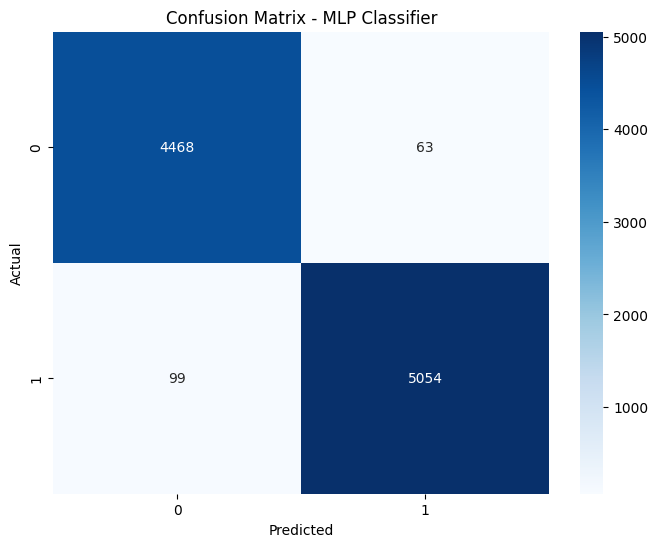

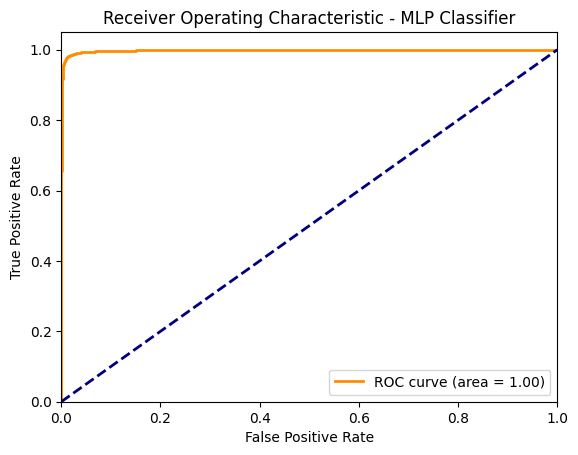

In [ ]:
# Evaluate MLP Classifier
evaluate_model(mlp, X_test, y_test, "MLP Classifier")

In [45]:
# Define individual models
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
lgb = LGBMClassifier()
cat = CatBoostClassifier(verbose=0)

# Create a Voting Classifier with soft voting
voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb),
    ('lgb', lgb),
    ('cat', cat)
], voting='soft')

In [46]:
# Fit the ensemble model
voting_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 24044, number of negative: 21143
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 45187, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532100 -> initscore=0.128577
[LightGBM] [Info] Start training from score 0.128577


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learn...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('lgb', LGBMClassifier()),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7811481028f0>)],
                 voting='soft')

Ensemble Model Classifier Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4531
         1.0       1.00      1.00      1.00      5153

    accuracy                           1.00      9684
   macro avg       1.00      1.00      1.00      9684
weighted avg       1.00      1.00      1.00      9684



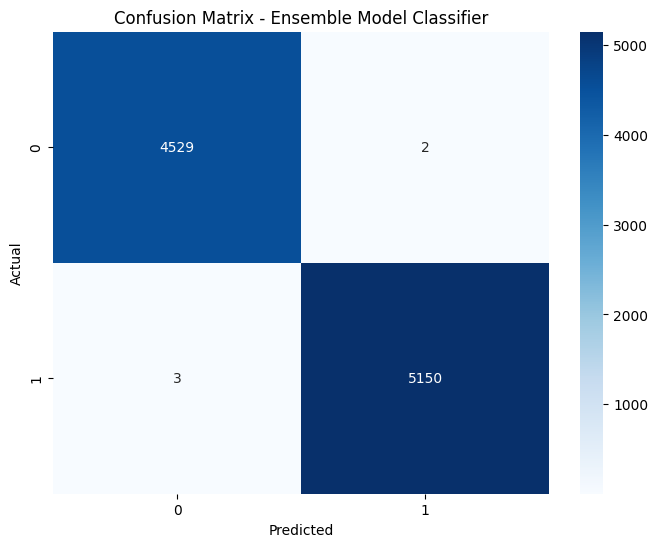

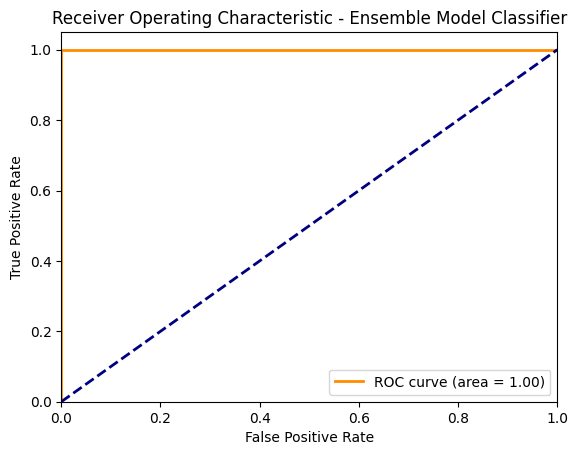

In [47]:
# Evaluate MLP Classifier
evaluate_model(voting_clf, X_test, y_test, "Ensemble Model Classifier")

In [48]:
# Prepare data for CNN and LSTM
X_train_cnn = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_cnn = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_cnn = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)


In [ ]:
# Compile CNN Model
cnn = Sequential([
    Conv1D(64, 2, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(2, activation='softmax')
])
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train CNN Model
cnn.fit(X_train_cnn, y_train_cat, validation_data=(X_val_cnn, y_val_cat), epochs=10, batch_size=32, callbacks=[early_stopping], verbose=1)

Epoch 1/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8915 - loss: 0.2575 - val_accuracy: 0.9402 - val_loss: 0.1529
Epoch 2/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9394 - loss: 0.1541 - val_accuracy: 0.9503 - val_loss: 0.1286
Epoch 3/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9470 - loss: 0.1347 - val_accuracy: 0.9540 - val_loss: 0.1161
Epoch 4/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9531 - loss: 0.1220 - val_accuracy: 0.9450 - val_loss: 0.1372
Epoch 5/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9539 - loss: 0.1202 - val_accuracy: 0.9497 - val_loss: 0.1426
Epoch 6/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9593 - loss: 0.1080 - val_accuracy: 0.9599 - val_loss: 0.1048
Epoch 7/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9602 - loss: 0.1039 - val_accuracy: 0.9608 - val_loss: 0.0996
Epoch 8/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9625 - loss: 0.0986 - 

303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
CNN Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4531
           1       0.96      0.97      0.97      5153

    accuracy                           0.97      9684
   macro avg       0.97      0.96      0.97      9684
weighted avg       0.97      0.97      0.97      9684



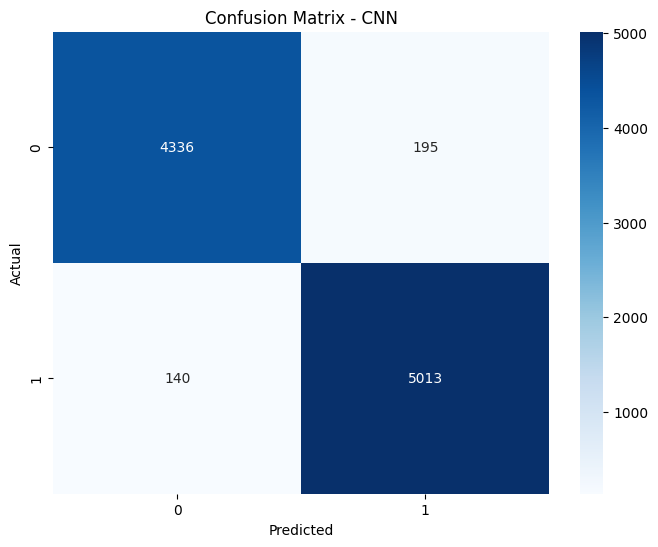

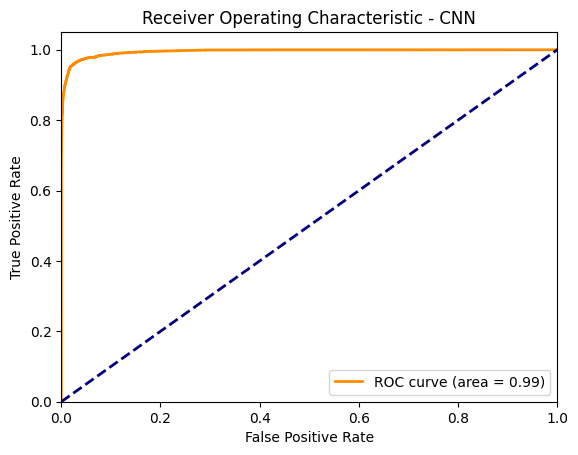

In [ ]:
# Evaluate CNN Model
y_pred_cnn = np.argmax(cnn.predict(X_test_cnn), axis=1)
evaluate_model(cnn, X_test_cnn, y_test_cat, "CNN")

In [ ]:
# Train and evaluate LSTM
lstm = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1)),
    Dense(100, activation='relu'),
    Dense(2, activation='softmax')
])
lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train LSTM Model
lstm.fit(X_train_cnn, y_train_cat, validation_data=(X_val_cnn, y_val_cat), epochs=10, batch_size=32, callbacks=[early_stopping], verbose=1)

Epoch 1/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8133 - loss: 0.3867 - val_accuracy: 0.9032 - val_loss: 0.2328
Epoch 2/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9049 - loss: 0.2183 - val_accuracy: 0.9261 - val_loss: 0.1840
Epoch 3/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9268 - loss: 0.1736 - val_accuracy: 0.9397 - val_loss: 0.1547


303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      4531
           1       0.90      0.92      0.91      5153

    accuracy                           0.90      9684
   macro avg       0.91      0.90      0.90      9684
weighted avg       0.90      0.90      0.90      9684



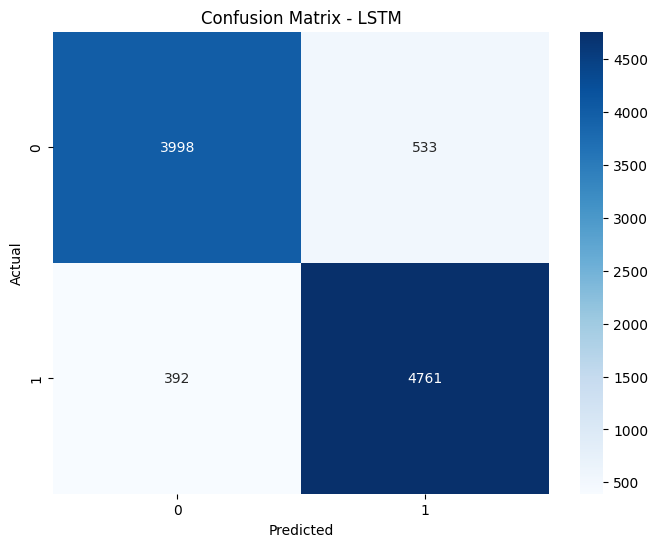

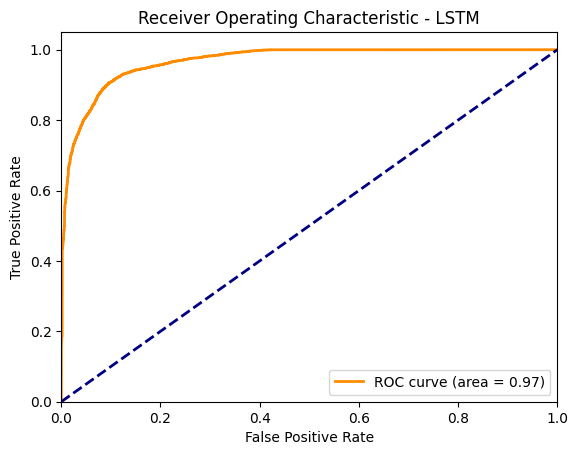

In [ ]:
# Evaluate LSTM Model
y_pred_lstm = np.argmax(lstm.predict(X_test_cnn), axis=1)
evaluate_model(lstm, X_test_cnn, y_test_cat, "LSTM")

In [52]:
# Initialize CNN-LSTM model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(100, return_sequences=True),
    Dropout(0.5),
    LSTM(50),
    Dropout(0.5),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
# Train the model
model.fit(X_train_cnn, y_train_cat, validation_data=(X_val_cnn, y_val_cat), epochs=10, batch_size=64)

Epoch 1/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7750 - loss: 0.4653 - val_accuracy: 0.9178 - val_loss: 0.1963
Epoch 2/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9120 - loss: 0.2162 - val_accuracy: 0.9252 - val_loss: 0.1825
Epoch 3/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9231 - loss: 0.1865 - val_accuracy: 0.9264 - val_loss: 0.1711
Epoch 4/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9312 - loss: 0.1707 - val_accuracy: 0.9382 - val_loss: 0.1512
Epoch 5/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9352 - loss: 0.1631 - val_accuracy: 0.9401 - val_loss: 0.1494
Epoch 6/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9403 - loss: 0.1557 - val_accuracy: 0.9412 - val_loss: 0.1427
Epoch 7/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9339 - loss: 0.1683 - val_accuracy: 0.9515 - val_loss: 0.1257
Epoch 8/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9474 - loss: 0.1372 - val_accura

303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Hybrid Model (CNN+LSTM) Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4531
           1       0.96      0.96      0.96      5153

    accuracy                           0.95      9684
   macro avg       0.95      0.95      0.95      9684
weighted avg       0.95      0.95      0.95      9684



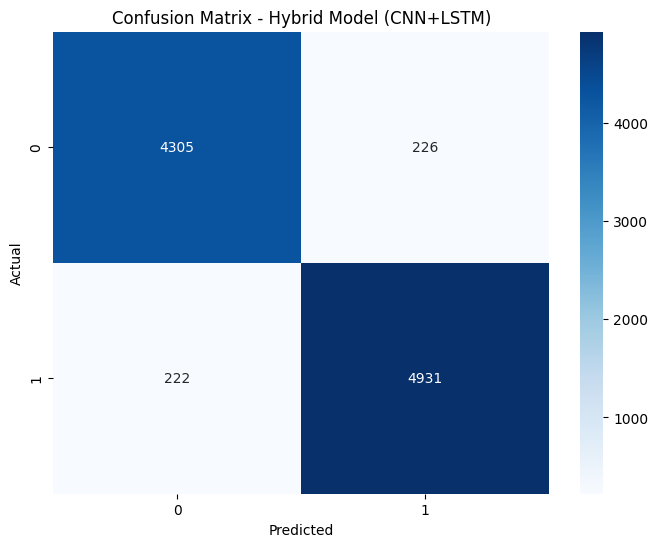

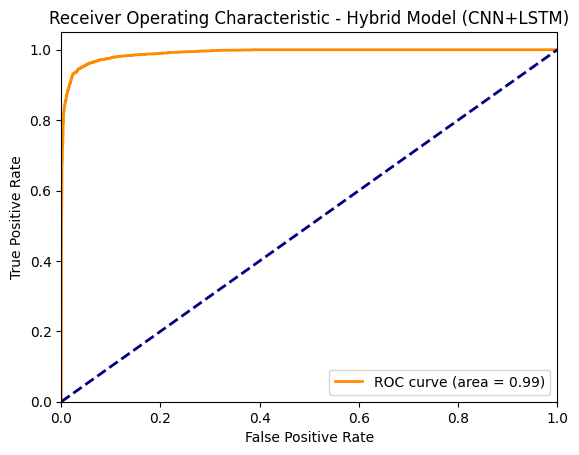

In [54]:
evaluate_model(model, X_test_cnn, y_test_cat, "Hybrid Model (CNN+LSTM)")